In [1]:
"""
Parts of this notebook are from CMU 11785 recitation.
"""

import sys
import numpy as np
import pandas as pd
import scipy
import scipy.sparse
from pathlib import Path
import copy
from tqdm import trange
import pickle
import copy

import matplotlib
from matplotlib import pyplot as plt
import seaborn
plt.rcParams.update({'font.size': 14})

import torch
import torch.nn as nn


In [2]:
torch.__version__

'2.0.1'

In [3]:
torch.cuda.is_available()

False

# Torch tensors

In [4]:
# Create from numpy array (seed for repeatability)
np.random.seed(123)
np_array = np.random.random((2,3))
print(torch.FloatTensor(np_array))
print(torch.from_numpy(np_array))

tensor([[0.6965, 0.2861, 0.2269],
        [0.5513, 0.7195, 0.4231]])
tensor([[0.6965, 0.2861, 0.2269],
        [0.5513, 0.7195, 0.4231]], dtype=torch.float64)


In [5]:
# special tensors (see documentation)
print(torch.eye(3))
print(torch.ones(2,3))
print(torch.zeros(2,3))
print(torch.arange(0,3))

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0, 1, 2])


In [6]:
x = torch.rand(3,5)  # CPU tensor
y = torch.rand(5,4).cuda()  # GPU tensor
print(x)
print(y)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# tensor operations require the same device
try:
    torch.mm(x,y)  # Operation between CPU and GPU fails
except TypeError as e:
    print(e)

# sklearn PCA

In [8]:
# simulate data
np.random.seed(0)
X = np.random.randn(1000, 100)

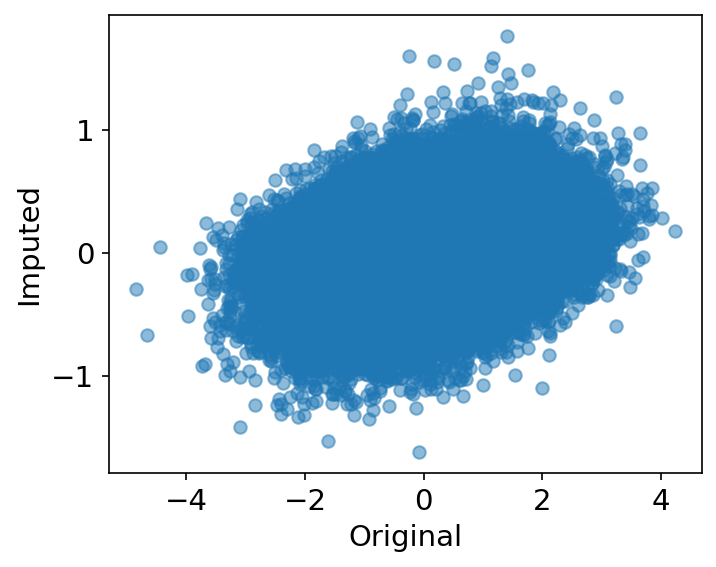

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
imputed_X = pca.inverse_transform(X_pca)

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150, facecolor="w")
ax.scatter(X.flatten(), imputed_X.flatten(), alpha=0.5)
ax.set_xlabel("Original")
ax.set_ylabel("Imputed")
fig.tight_layout()
fig.show()

# Using Pytorch autograd for optimizing matrix factorization

### the objective function of matrix factorization

Let $X \in \mathbb{R}^{n \times d}$ be the data matrix with $n$ samples and $d$ features, we want to find two low-rank matrices of rank $k$ such that their multiplication approximates $X$.
\begin{equation}
\argmin_{\substack{U \in \mathbb{R}^{n \times k} \\ V\in \mathbb{R}^{k \times d}}} \| X - UV \|_F^2
\end{equation}


In [10]:
# Note that the input of PCA is usually mean-centered
X_meancenter = X - X.mean(axis=0)

# convert the mean-centered data matrix to torch tensor
X_meancenter_torch = torch.tensor(X_meancenter, dtype=torch.float32)

### Simply define parameters for autogradient

In [13]:
n_samples = X.shape[0]
n_components = 5
n_features = X.shape[1]

U = nn.Parameter(torch.rand(n_samples, n_components), requires_grad=True)
V = nn.Parameter(torch.rand(n_components, n_features), requires_grad=True)

In [15]:
# define loss
loss_fn = nn.MSELoss(reduction="sum")
loss = loss_fn(X_meancenter_torch, torch.matmul(U,V))
print(f"loss = {loss.item()}")

# compare with manually computed loss
manual_loss = np.sum(np.square( X_meancenter - U.detach().cpu().numpy() @ V.detach().cpu().numpy() ))
print(f"Manually computed loss = {manual_loss}")

loss = 276483.75
Manually computed loss = 276483.75329107087


In [17]:
# we haven't computed gradient yet, but what if we try to print it now
print(U.grad)
print(V.grad)

None
None


In [18]:
# compute gradient
loss.backward()

print(U.grad)
print(V.grad)

tensor([[120.5667, 116.9967, 116.9759, 116.4917, 118.1466],
        [158.0322, 155.3625, 155.5901, 141.5036, 160.9853],
        [ 53.9159,  62.6293,  53.3734,  64.7308,  67.4067],
        ...,
        [134.3625, 148.3253, 130.9175, 150.7103, 150.7507],
        [120.6287, 111.8071, 116.6018, 121.8338, 121.0355],
        [ 63.9229,  75.2644,  81.3994,  73.8571,  75.3793]])
tensor([[1574.8370, 1593.7808, 1433.5337, 1038.2810, 1187.9044, 1690.6355,
         1632.7253, 1083.6952, 1777.9993, 1843.4688, 1531.4532, 1875.8545,
          628.7040,  861.1492,  782.1672,  566.5986, 1017.4788, 1224.2766,
         1692.1077, 1113.7920, 1192.4991,  725.9580,  952.1599, 1478.5452,
         1278.9856, 1517.4893, 1726.8833, 1597.3893, 1194.7086, 1453.8461,
         1585.2329,  681.8011, 1234.0415,  391.8979, 1496.5208, 1091.5570,
          811.5767, 1459.4617, 1582.7365, 1470.4421, 1443.9878,  953.6354,
         1946.6399, 1613.8228,  960.2726, 1146.9674, 1034.1238, 1270.2089,
          512.1182, 1030.4

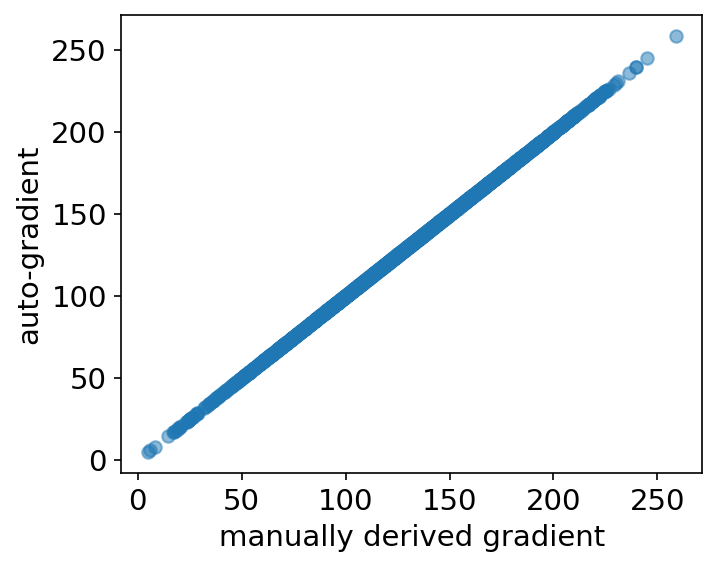

In [19]:
# compare U gradient with manually computed gradient
manual_U_grad = -2 * X_meancenter @ V.detach().cpu().numpy().T + 2 * U.detach().cpu().numpy() @ V.detach().cpu().numpy() @ V.detach().cpu().numpy().T

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150, facecolor="w")
ax.scatter(U.grad.detach().cpu().numpy().flatten(), manual_U_grad.flatten(), alpha=0.5)
ax.set_xlabel("manually derived gradient")
ax.set_ylabel("auto-gradient")
fig.tight_layout()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1769.49it/s]


91317.46875


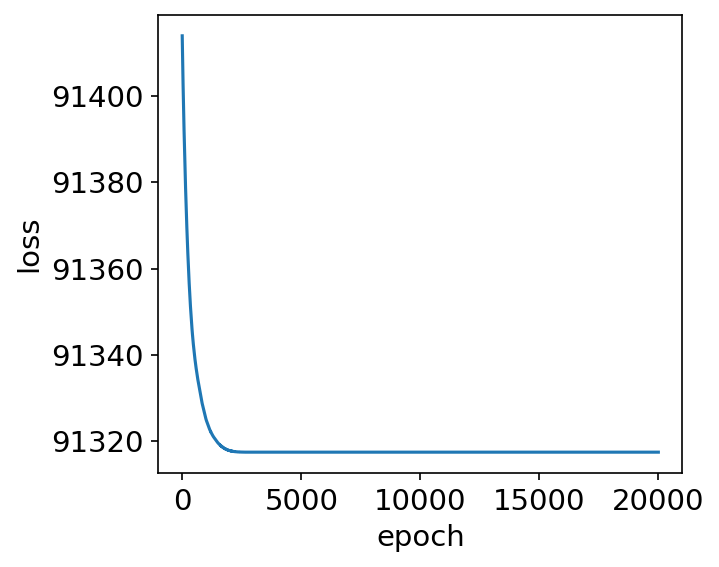

In [22]:
# one can use the auto-computed gradient to write their own gradient descent update
# but there technicalities, including step size, whether to use momentum, etc.
# So let's use pytorch-implemented optimizer

optimizer = torch.optim.Adam([U, V], lr=5e-4)
# number of gradient descent steps to run
n_epoch = 20000
# a list to record losses of each step
loss_list = []

for epoch in trange(n_epoch):
    # clear the gradient of previous steps
    optimizer.zero_grad()
    # loss function: evaluate the deviation between UV and X
    loss = loss_fn(X_meancenter_torch, torch.matmul(U,V))
    # compute the gradient of current step
    loss.backward()
    # update model parameters
    optimizer.step()
    # record loss
    loss_list.append(loss.item())

print(loss_list[-1])
# plot loss
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150, facecolor="w")
ax.plot(loss_list)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
fig.tight_layout()
plt.show()

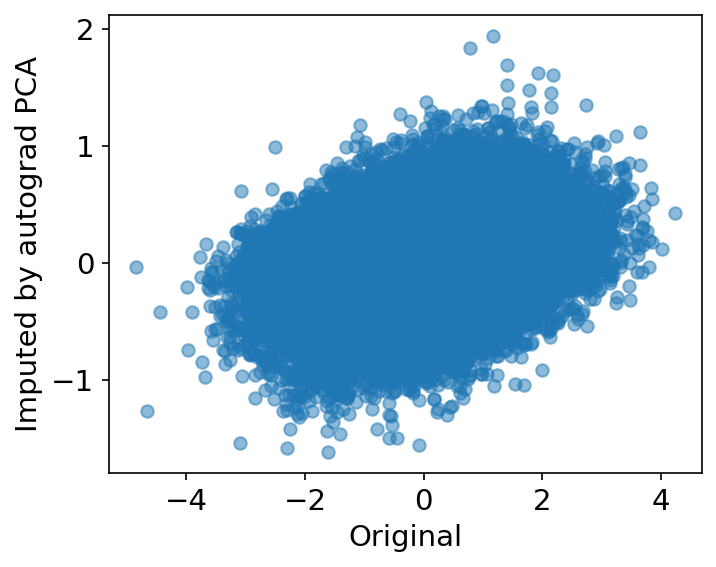

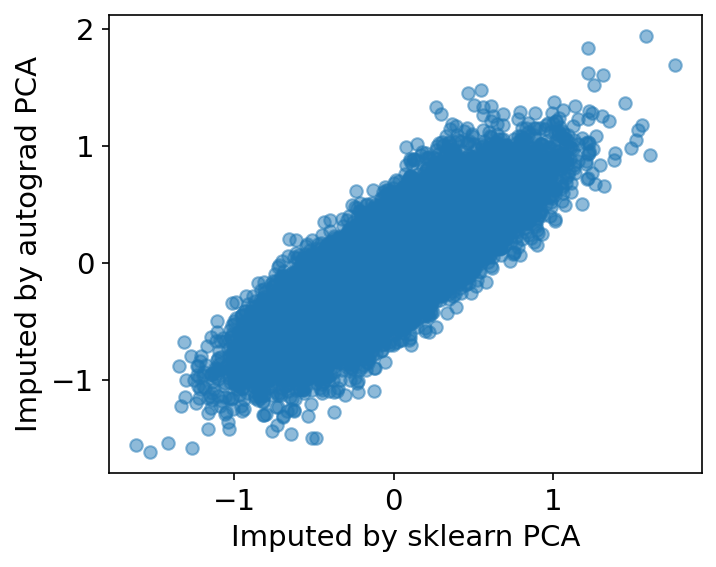

In [23]:
imputed_X_autograd = torch.matmul(U,V).detach().cpu().numpy() + X.mean(axis=0)

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150, facecolor="w")
ax.scatter(X.flatten(), imputed_X_autograd.flatten(), alpha=0.5)
ax.set_xlabel("Original")
ax.set_ylabel("Imputed by autograd PCA")
fig.tight_layout()
fig.show()

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150, facecolor="w")
ax.scatter(imputed_X.flatten(), imputed_X_autograd.flatten(), alpha=0.5)
ax.set_xlabel("Imputed by sklearn PCA")
ax.set_ylabel("Imputed by autograd PCA")
fig.tight_layout()
fig.show()

### A structured torch "model" rather than individual parameters

In [24]:
class torch_pca(nn.Module):
    """
    Specify parameters in the optimization
    """
    def __init__(self, n_samples, n_features, n_components):
        super().__init__()
        # initialize low-dimensional matrices
        U_ = torch.rand(n_samples, n_components)
        V_ = torch.rand(n_components, n_features)
        self.U = nn.Parameter(U_, requires_grad=True)
        self.V = nn.Parameter(V_, requires_grad=True)

    """
    Specify the calculation using parameters.
    All steps in forward function will be considered in autogradient.
    """
    def forward(self):
        return torch.matmul(self.U, self.V)

Initialize model

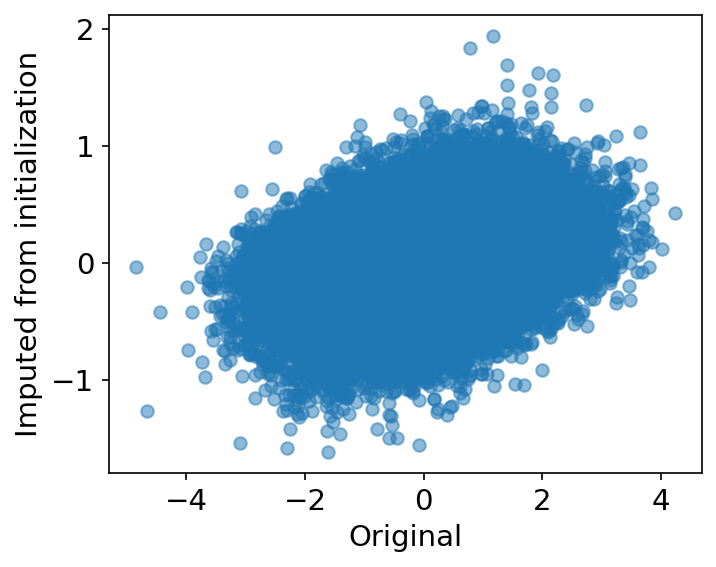

In [25]:
model = torch_pca(n_samples=X.shape[0], n_features=X.shape[1], n_components=5)

# forward pass, initial matrix factorization
initial_imputation = model().detach().cpu().numpy()

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150, facecolor="w")
ax.scatter(X.flatten(), imputed_X_autograd.flatten(), alpha=0.5)
ax.set_xlabel("Original")
ax.set_ylabel("Imputed from initialization")
fig.tight_layout()
fig.show()

### Autogradient optimization

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1748.87it/s]


91317.46875


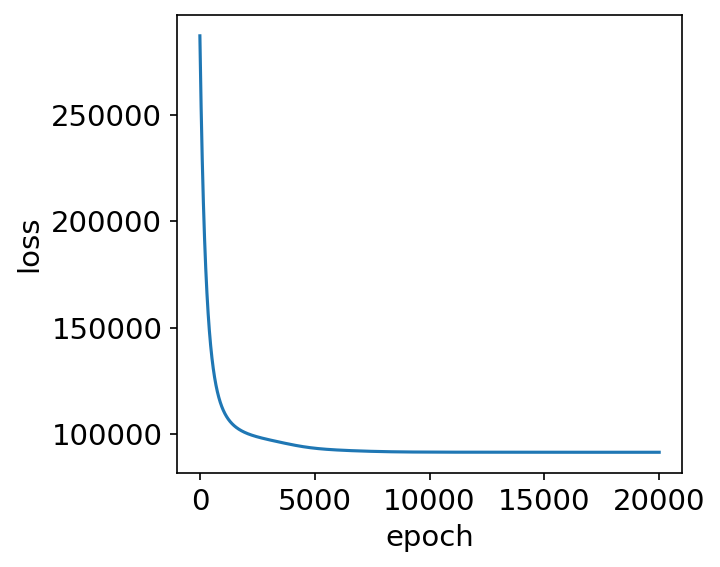

In [26]:
loss_fn = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# number of gradient descent steps to run
n_epoch = 20000
# a list to record losses of each step
loss_list = []

for epoch in trange(n_epoch):
    # clear the gradient of previous steps
    optimizer.zero_grad()
    # forward pass, which gives UV
    out = model.forward()
    # loss function: evaluate the deviation between UV and X
    loss = loss_fn(X_meancenter_torch, out)
    # compute the gradient of current step
    loss.backward()
    # update model parameters
    optimizer.step()
    # record loss
    loss_list.append(loss.item())

print(loss_list[-1])
# plot loss
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150, facecolor="w")
ax.plot(loss_list)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
fig.tight_layout()
plt.show()

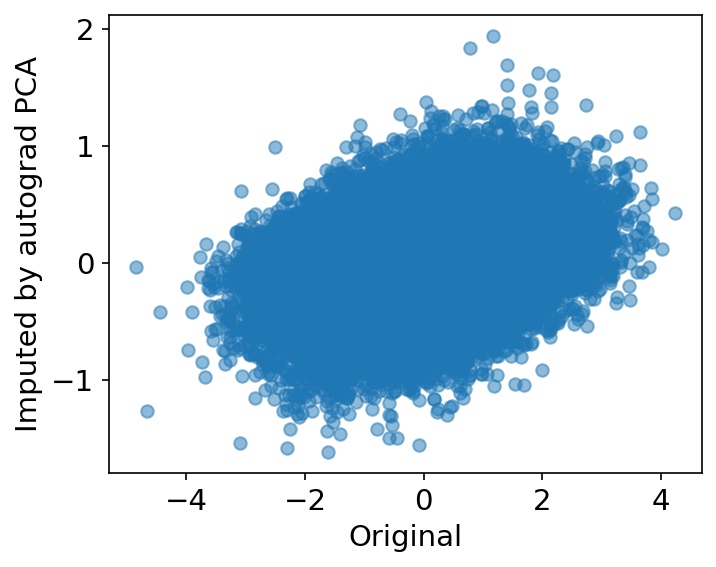

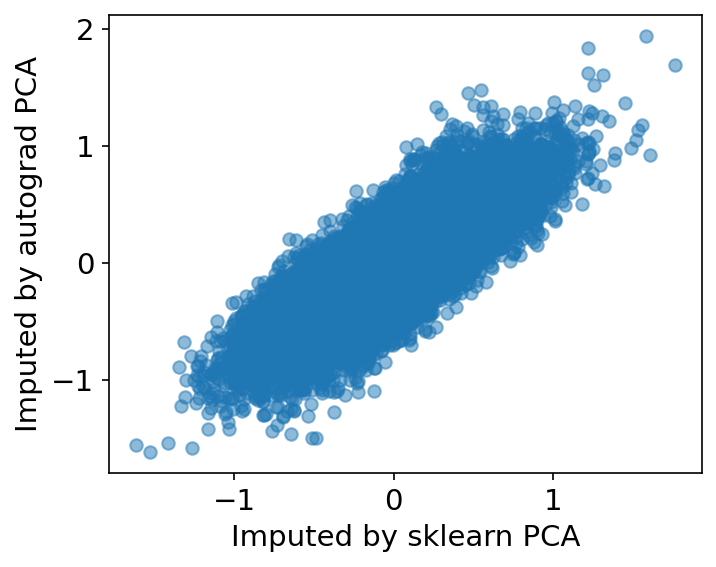

In [27]:
imputed_X_autograd = model().detach().cpu().numpy() + X.mean(axis=0)

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150, facecolor="w")
ax.scatter(X.flatten(), imputed_X_autograd.flatten(), alpha=0.5)
ax.set_xlabel("Original")
ax.set_ylabel("Imputed by autograd PCA")
fig.tight_layout()
fig.show()

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150, facecolor="w")
ax.scatter(imputed_X.flatten(), imputed_X_autograd.flatten(), alpha=0.5)
ax.set_xlabel("Imputed by sklearn PCA")
ax.set_ylabel("Imputed by autograd PCA")
fig.tight_layout()
fig.show()

# Multi-layer perceptron (MLP)

Given a 2D space, let's assume points inside the circle $x_1^2 + x_2^2 = 1$ belong to the first class, and points outside belong to the second class.

Suppose we don't know the decision boundary, and want to learn it from observed data. We pose a logistic regression problem, where the probability of a 2D point $\mathbf{w}$ belongs to the first class is
\begin{equation}
\mathbb{P}(y = 1) = \frac{e^{f(\mathbf{x})}}{ e^{f(\mathbf{x})} + e^{g(\mathbf{x})} },
\end{equation}
and the probability for it to belong to the second class is
\begin{equation}
\mathbb{P}(y = 2) = \frac{e^{g(\mathbf{x})}}{ e^{f(\mathbf{x})} + e^{g(\mathbf{x})} }.
\end{equation}

Given observed points $\mathbf{x}_1, \dots, \mathbf{x}_n$, and corresponding class labels $y_1, \dots, y_n$, we maximize the following likelihood function:
\begin{equation}
\max_{f, g} \sum_{i=1}^n \mathbf{1}_{y_i=1} \log \frac{e^{f(\mathbf{x})}}{ e^{f(\mathbf{x})} + e^{g(\mathbf{x})} } + \mathbf{1}_{y_i=2} \log \frac{e^{g(\mathbf{x})}}{ e^{f(\mathbf{x})} + e^{g(\mathbf{x})} }.
\end{equation}


Function $f$ and $g$ can be approximated by a multi-layer perceptron (MLP). How does it approximate? And how good is the approximation?

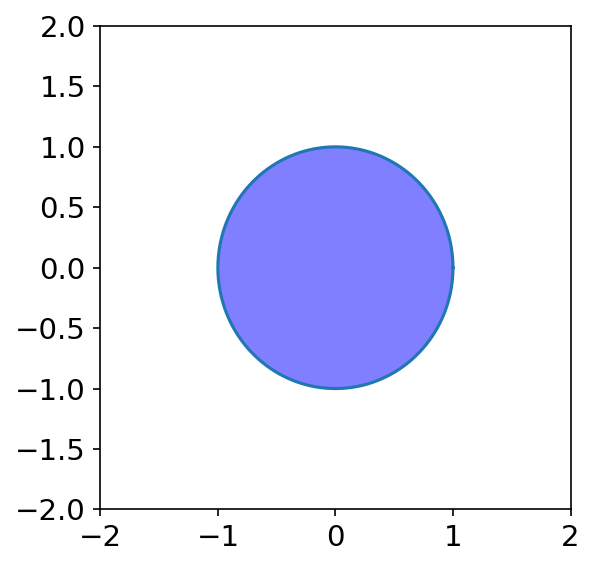

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150, facecolor="w")
x = np.cos( np.arange(0, 2*np.pi, 0.001) )
y = np.sin( np.arange(0, 2*np.pi, 0.001) )
ax.plot(x, y)
ax.fill_between( np.cos(np.arange(0, np.pi, 0.001)), np.sin(np.arange(0, np.pi, 0.001)), -np.sin(np.arange(0, np.pi, 0.001)), facecolor="blue", alpha=0.5)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
fig.tight_layout()
fig.show()

In [5]:
def sample_points(n):
    # returns (X,Y), where X of shape (n,2) is the numpy array of points and Y is the (n) array of classes
    
    radius = np.random.uniform(low=0,high=2,size=n).reshape(-1,1) # uniform radius between 0 and 2
    angle = np.random.uniform(low=0,high=2*np.pi,size=n).reshape(-1,1) # uniform angle
    x1 = radius*np.cos(angle)
    x2=radius*np.sin(angle)
    y = (radius<1).astype(int).reshape(-1)
    x = np.concatenate([x1,x2],axis=1)
    return x,y

In [6]:
# Generate the data
np.random.seed(0)

trainx,trainy = sample_points(10000)
testx,testy = sample_points(500)

# convert to torch tensors
train_data = torch.from_numpy(trainx).float()
train_labels = torch.from_numpy(trainy.reshape(-1,1)).float()

print(trainx.shape,trainy.shape)

(10000, 2) (10000,)


In [7]:
class MLP_predictor(nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.linear1 = nn.Linear(2,n_hidden_neurons)
        self.act1 = nn.ReLU()
        # the last linear layer project n_hidden_neurons to one value, which is our f(x) evaluated at a given x
        self.linear2 = nn.Linear(n_hidden_neurons,1)
        # convert the f(x) to probability
        self.act2 = nn.Sigmoid()
        
    def forward(self, x):
        return self.act2(self.linear2(self.act1(self.linear1(x))))


In [8]:
# initialize model with 4 hidden neurons
model1 = MLP_predictor(4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1002.20it/s]


0.03363427147269249


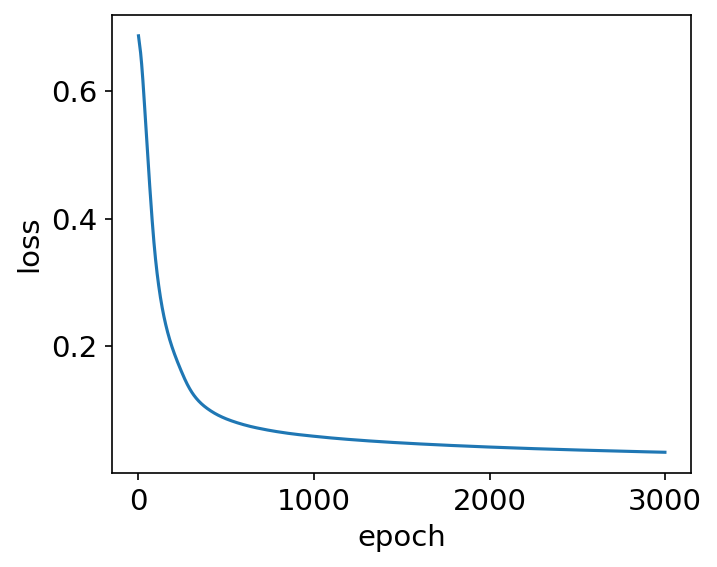

In [9]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
# number of gradient descent steps to run
n_epoch = 3000
# a list to record losses of each step
loss_list = []

for epoch in trange(n_epoch):
    # clear the gradient of previous steps
    optimizer.zero_grad()
    # forward pass, which gives UV
    out = model1.forward(train_data)
    # loss function: evaluate the deviation between UV and X
    loss = loss_fn(out, train_labels)
    # compute the gradient of current step
    loss.backward()
    # update model parameters
    optimizer.step()
    # record loss
    loss_list.append(loss.item())

print(loss_list[-1])
# plot loss
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150, facecolor="w")
ax.plot(loss_list)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
fig.tight_layout()
plt.show()

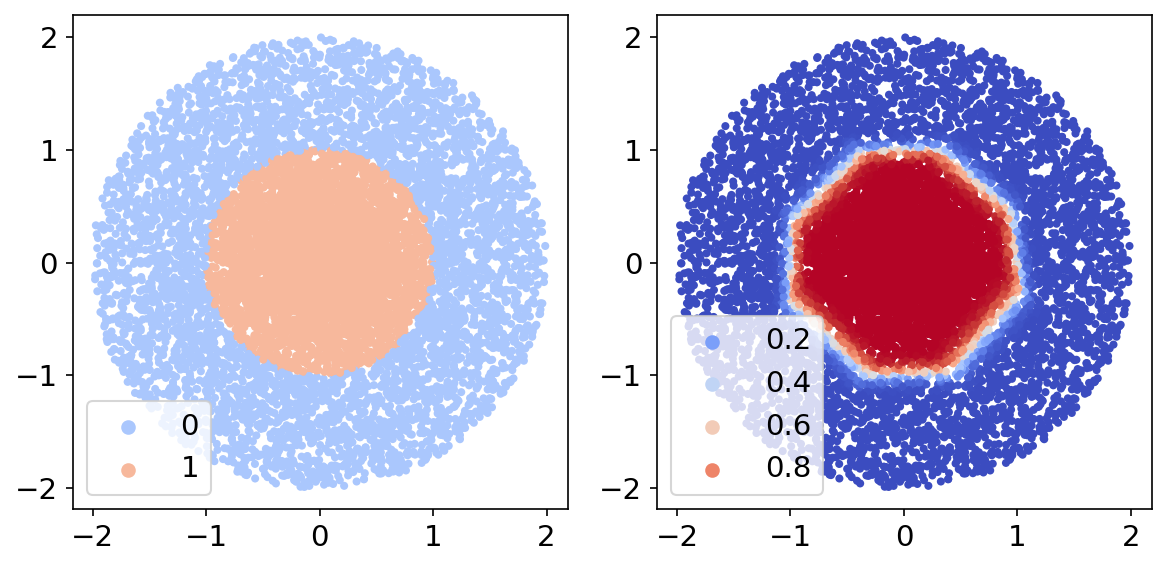

In [10]:
# visualize accuracy
pred = model1(train_data).detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(8,4), dpi=150, facecolor="white")
seaborn.scatterplot(x=trainx[:,0], y=trainx[:,1], hue=trainy, palette="coolwarm", s=15, linewidth=0, ax=axes[0])
seaborn.scatterplot(x=trainx[:,0], y=trainx[:,1], hue=pred.flatten(), palette="coolwarm", s=15, linewidth=0, ax=axes[1])
fig.tight_layout()
fig.show()

The right panel of the above plot has a polygon-shaped decision boundary. Why does this happen?

Let's decompose the linear layers. In first layer, there are 4 neurons, each has slopes (weight) $\mathbf{w}_1, \dots, \mathbf{w}_4 \in \mathbb{R}^2$ and intercept (bias) $b_1, \dots, b_4 \in \mathbb{R}$. Let the ReLU activation function be $\sigma: \mathbb{R} \rightarrow \mathbb{R}$.
Denote the values of the six neurons in the hidden layers as $z_1, \dots, z_4$, then
\begin{equation*}
z_i = \sigma (\mathbf{w}_i^T \mathbf{x} + b_i).
\end{equation*}

Let's take a look of the values of hidden neurons.

(10000, 4)


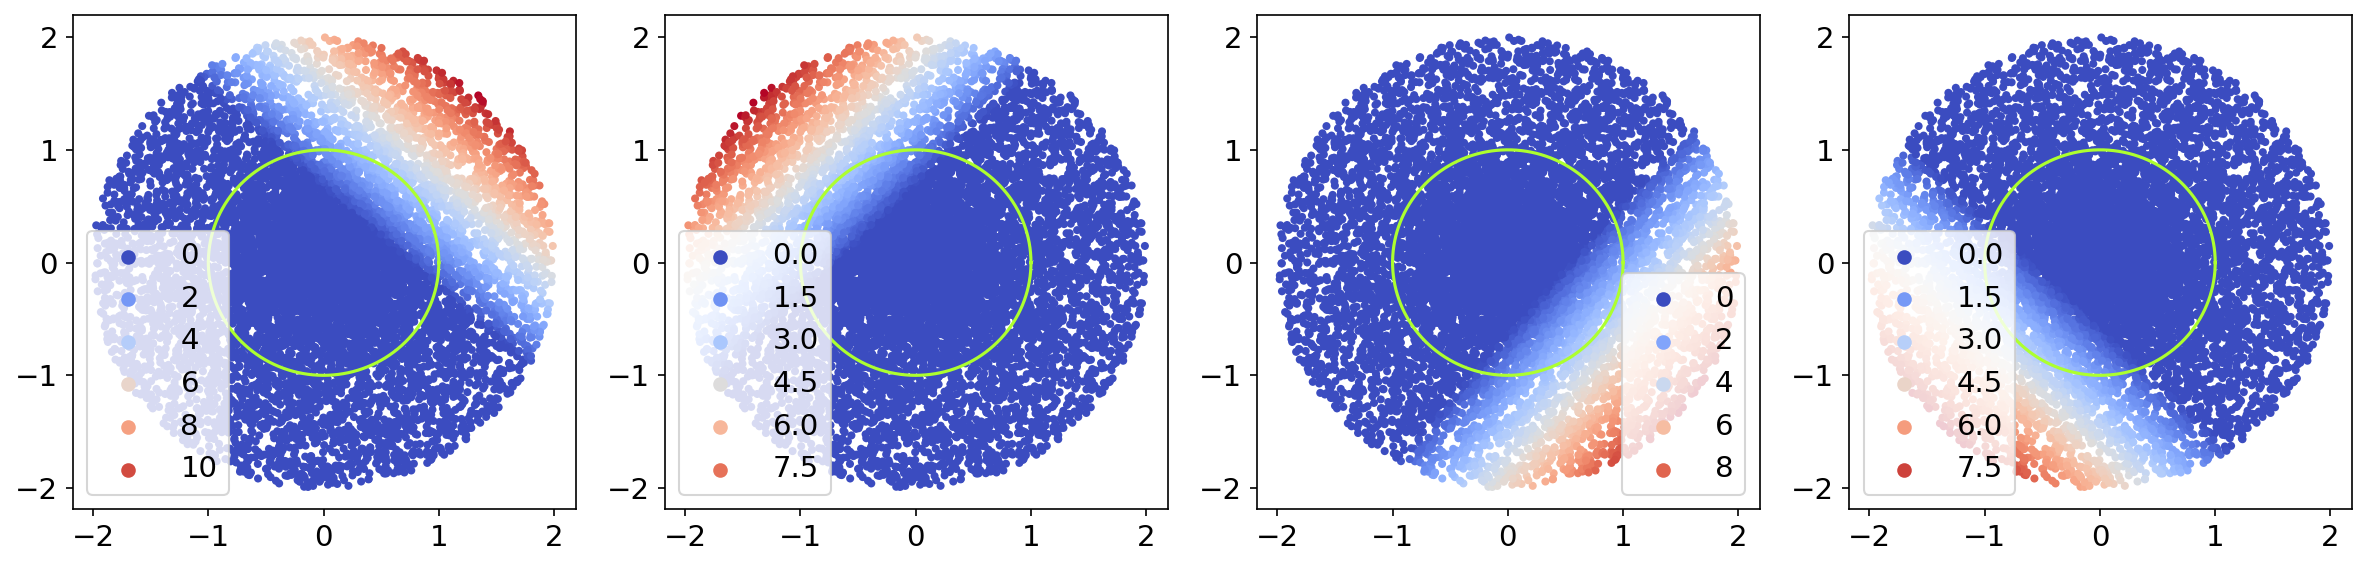

In [13]:
z = model1.act1( model1.linear1(train_data) )
z = z.detach().cpu().numpy()
print( z.shape )

fig, axes = plt.subplots(1, 4, figsize=(16,4), dpi=150, facecolor="white")
for col in range(4):
    seaborn.scatterplot(x=trainx[:,0], y=trainx[:,1], hue=z[:,col], palette="coolwarm", s=15, linewidth=0, ax=axes[col])
    x = np.cos( np.arange(0, 2*np.pi, 0.001) )
    y = np.sin( np.arange(0, 2*np.pi, 0.001) )
    axes[col].plot(x, y, c="greenyellow")
fig.tight_layout()
fig.show()

In [14]:
model1.linear2.weight, model1.linear2.bias

(Parameter containing:
 tensor([[-3.6671, -4.4173, -3.9366, -4.5973]], requires_grad=True),
 Parameter containing:
 tensor([12.4661], requires_grad=True))

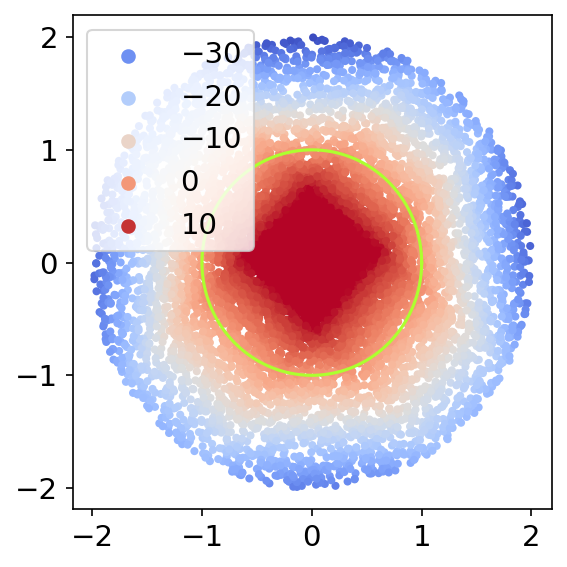

In [15]:
z = model1.act1( model1.linear1(train_data) )
z1 = model1.linear2(z)

fig, axes = plt.subplots(1, 1, figsize=(4,4), dpi=150, facecolor="white")
seaborn.scatterplot(x=trainx[:,0], y=trainx[:,1], hue=z1.detach().cpu().numpy().flatten(), palette="coolwarm", s=15, linewidth=0, ax=axes)
x = np.cos( np.arange(0, 2*np.pi, 0.001) )
y = np.sin( np.arange(0, 2*np.pi, 0.001) )
axes.plot(x, y, c="greenyellow")
fig.tight_layout()
fig.show()